

Uncomment and run the below cell the first time the notebook is run.



# Installation and Initializations

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")
!source /content/drive/MyDrive/venv/bin/activate

Mounted at /content/drive/


In [ ]:
# Used Python 3.10 for this notebook

!pip install torch
!pip install torchvision
!pip install e3nn

# The below helps make the torch_geometric installation go faster

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

!pip install torch_geometric
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 52.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 81.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [ ]:
# Using file from my Google Drive, data taken from http://www.sgdml.org/#datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import numpy as np

# Diffusion
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from google.colab import drive
import os

# Plot style
import seaborn as sns
sns.set_style("ticks")
sns.set_palette("pastel")

# More diffusion
import networkx as nx


drive.mount('/content/drive/')
os.chdir("/content/drive/MyDrive/trajectories/aspirin")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Visualizing molecular trajectories

In [ ]:
from torch_geometric.loader import DataLoader

def parse_xyz_multi_frame(filepath):
    with open(filepath, 'r') as file:
        frames = []
        while True:
            line = file.readline()
            if not line:
                break
            num_atoms = int(line.strip())  # Number of atoms
            file.readline()  # Comment line
            atoms = []
            coordinates = np.zeros((num_atoms, 3))
            for i in range(num_atoms):
                line = file.readline().strip().split()
                atoms.append(line[0])  # Atom type
                coordinates[i] = [float(x) for x in line[1:4]]  # X, Y, Z
            frames.append((atoms, coordinates))
    return frames

covalent_radii = {'C': 0.77, 'H': 0.37, 'O': 0.73}

def calculate_bond_connectivity(atoms, coordinates, covalent_radii, tolerance=0.4):
    bond_connectivities = {i: [] for i in range(len(atoms))}
    for i in range(len(atoms)):
        for j in range(i+1, len(atoms)):
            d = np.linalg.norm(coordinates[i] - coordinates[j])
            if d < (covalent_radii.get(atoms[i], 0) + covalent_radii.get(atoms[j], 0) + tolerance):
                bond_connectivities[i].append(j)
                bond_connectivities[j].append(i)
    return bond_connectivities

def create_graph_data(atoms, coordinates, bond_connectivities):
    node_features = torch.tensor(coordinates, dtype=torch.float)
    edge_index = []
    for atom1, bonded_atoms in bond_connectivities.items():
        for atom2 in bonded_atoms:
            if atom1 < atom2:
                edge_index.append([atom1, atom2])
                edge_index.append([atom2, atom1])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    graph_data = Data(x=node_features, edge_index=edge_index)
    return graph_data

frames_train = parse_xyz_multi_frame('aspirin_ccsd-train.xyz')
frames_test = parse_xyz_multi_frame('aspirin_ccsd-test.xyz')
combined_frames = frames_train + frames_test
frames_train = combined_frames[:1350]
frames_test = combined_frames[1350:]

graph_data_train = [create_graph_data(frame[0], frame[1], calculate_bond_connectivity(frame[0], frame[1], covalent_radii)) for frame in frames_train]
graph_data_test = [create_graph_data(frame[0], frame[1], calculate_bond_connectivity(frame[0], frame[1], covalent_radii)) for frame in frames_test]

train_loader = DataLoader(graph_data_train, batch_size=1, shuffle=True)
test_loader = DataLoader(graph_data_test, batch_size=1, shuffle=False)

# GCN model

Epoch 1: Loss = 0.26296872207412014
Epoch 2: Loss = 0.15998075093384143
Epoch 3: Loss = 0.15213748112872794
Epoch 4: Loss = 0.14806979488443445
Epoch 5: Loss = 0.14511372051857135
Epoch 6: Loss = 0.14188477270581104
Epoch 7: Loss = 0.13865144793082165
Epoch 8: Loss = 0.13546474561095237
Epoch 9: Loss = 0.13271247526009877
Epoch 10: Loss = 0.13031638001954113
Epoch 11: Loss = 0.12848797977522566
Epoch 12: Loss = 0.1270753178662724
Epoch 13: Loss = 0.1257517388076694
Epoch 14: Loss = 0.12456212398078706
Epoch 15: Loss = 0.12370733275457665
Epoch 16: Loss = 0.12286411725812488
Epoch 17: Loss = 0.12207328650686476
Epoch 18: Loss = 0.12121222545151357
Epoch 19: Loss = 0.12055000386304325
Epoch 20: Loss = 0.11971908562161304
Epoch 21: Loss = 0.11922415432002809
Epoch 22: Loss = 0.11854813813611313
Epoch 23: Loss = 0.11786999651679286
Epoch 24: Loss = 0.11728672812934275
Epoch 25: Loss = 0.11682372798522313
Epoch 26: Loss = 0.11623200281350701
Epoch 27: Loss = 0.11576336777872509
Epoch 28: Lo

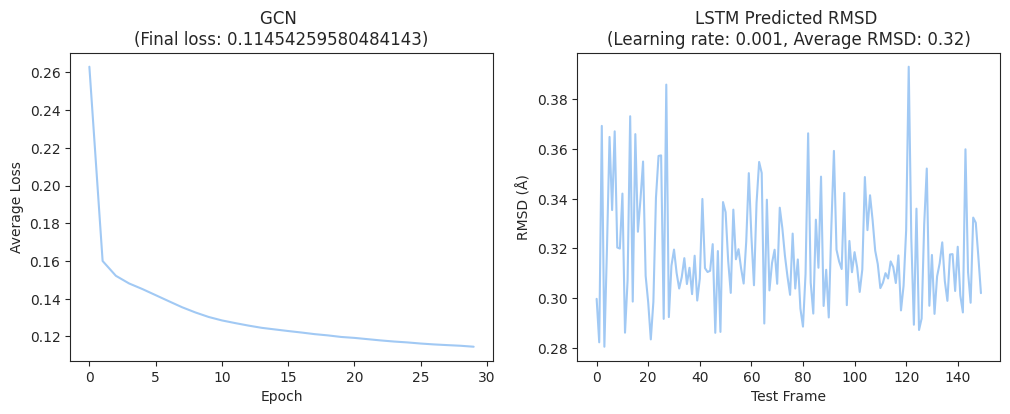

In [ ]:
from torch_geometric.nn import GCNConv

class GCNDiffusionModel(torch.nn.Module):
    def __init__(self, node_features, hidden_dim):
        super(GCNDiffusionModel, self).__init__()
        self.conv1 = GCNConv(node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, node_features)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

node_features = graph_data_train[0].num_node_features
model = GCNDiffusionModel(node_features, hidden_dim=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses = []

# Training loop
for epoch in range(30):
    model.train()
    total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data.x)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}: Loss = {avg_loss}")

# Plot training loss
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f"GCN \n(Final loss: {train_losses[-1]})")

def calculate_rmsd(predicted, actual):
    # Ensure numpy arrays and correct shapes
    predicted = np.array(predicted)
    actual = np.array(actual)
    if predicted.shape != actual.shape:
        raise ValueError("Shape of predicted and actual coordinates must be the same")

    # Calculate RMSD
    rmsd = np.sqrt(np.mean((predicted - actual) ** 2, axis=1))
    return rmsd

model.eval()
rmsd_values_test = []

with torch.no_grad():
    for data in test_loader:
        output = model(data)
        rmsd = calculate_rmsd(output.numpy(), data.x.numpy())
        rmsd_values_test.append(rmsd.mean())
avg_rmsd_gcn = np.mean(rmsd_values_test)

# Plot RMSD for test data
plt.subplot(1, 2, 2)
plt.plot(rmsd_values_test)
plt.xlabel('Test Frame')
plt.ylabel('RMSD (Å)')
plt.title(f'LSTM Predicted RMSD \n(Learning rate: 0.001, Average RMSD: {avg_rmsd_gcn:.2f})')
plt.show()

# Focusing on the diffusion model but for graph representation

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
import torch.optim as optim

# Function to adjust the graph size (number of nodes)
def adjust_graph_size(x, edge_index, max_nodes, node_feature_dim):
    num_nodes = x.size(0)
    # Check if the node feature dimension is correct
    if x.size(1) != node_feature_dim:
        raise ValueError(f"The node feature dimension of x should be {node_feature_dim}, but got {x.size(1)}")

    # Padding
    if num_nodes < max_nodes:
        padding = torch.zeros(max_nodes - num_nodes, node_feature_dim, device=x.device)
        x_padded = torch.cat([x, padding], dim=0)
        edge_index_padded = edge_index.clone()  # No change in edge_index for padding
        return x_padded, edge_index_padded

    # Trimming
    elif num_nodes > max_nodes:
        x_trimmed = x[:max_nodes]
        mask = (edge_index < max_nodes).all(dim=0)
        edge_index_trimmed = edge_index[:, mask]
        return x_trimmed, edge_index_trimmed

    return x, edge_index

# Graph U-Net model
class GraphUNet(nn.Module):
    def __init__(self, in_channels, hidden_channels, max_nodes, node_feature_dim):
        super(GraphUNet, self).__init__()
        self.max_nodes = max_nodes
        self.node_feature_dim = node_feature_dim
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.pool1 = TopKPooling(hidden_channels, ratio=0.8)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pool2 = TopKPooling(hidden_channels, ratio=0.8)
        self.upconv1 = GCNConv(hidden_channels, hidden_channels)
        self.upconv2 = GCNConv(hidden_channels, in_channels)

    def forward(self, x, edge_index, batch):
        x, edge_index = adjust_graph_size(x, edge_index, self.max_nodes, self.node_feature_dim)
        # Downsampling
        x1 = F.relu(self.conv1(x, edge_index))
        x1, edge_index1, _, batch1, _, _ = self.pool1(x1, edge_index, None, batch)
        x2 = F.relu(self.conv2(x1, edge_index1))
        x2, edge_index2, _, batch2, _, _ = self.pool2(x2, edge_index1, None, batch1)
        # Upsampling
        x = F.relu(self.upconv1(x2, edge_index2))
        x = F.relu(self.upconv2(x, edge_index1))  # Using edge_index1 from the first pooling layer
        return global_mean_pool(x, batch)

# Helper functions for diffusion
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    device = vals.device
    out = vals.gather(-1, t.to(device))
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1)))

def forward_diffusion_sample(x, t, alphas_cumprod, device):
    noise = torch.randn_like(x, device=device)
    sqrt_alphas_cumprod_t = get_index_from_list(alphas_cumprod, t, x.shape).sqrt_().to(device)
    noisy_x = sqrt_alphas_cumprod_t * x + (1 - sqrt_alphas_cumprod_t**2).sqrt() * noise
    return noisy_x, noise

# Graph Diffusion Model
class GraphDiffusionModel(nn.Module):
    def __init__(self, timesteps, node_feature_dim, hidden_channels, max_nodes, device):
        super(GraphDiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.device = device
        self.max_nodes = max_nodes
        self.betas = linear_beta_schedule(timesteps).to(device)
        self.alphas = 1 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.unet = GraphUNet(node_feature_dim, hidden_channels, max_nodes, node_feature_dim).to(device)

    def forward(self, graph_data, t):
        x = graph_data.x
        edge_index = graph_data.edge_index
        batch = graph_data.batch
        node_feature_dim = x.size(1)
        x, edge_index = adjust_graph_size(x, edge_index, self.max_nodes, node_feature_dim)
        noisy_x, _ = forward_diffusion_sample(x, t, self.alphas_cumprod, self.device)
        return self.unet(noisy_x, edge_index, batch)

# Training setup (assumes existence of graph_data_train)
from torch_geometric.loader import DataLoader
import matplotlib.pyplot as plt

T = 100


In [ ]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GraphDiffusionModel(timesteps=T, node_feature_dim=3, hidden_channels=16, max_nodes=100, device=device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Assuming graph_data_train is a list or dataset of graph data
train_loader = DataLoader(graph_data_train, batch_size=1)

# Training loop
training_losses = []
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for graph_data in train_loader:
        graph_data = graph_data.to(device)
        t = torch.randint(0, T, (graph_data.num_graphs,), device=device)
        optimizer.zero_grad()
        output = model(graph_data, t)
        loss = criterion(output, graph_data.x.to(device))  # Ensure the target is on the correct device
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    training_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Avg Loss: {avg_loss:.4f}")

# Plotting the training loss
plt.figure(figsize=(12, 4))
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title(f'Graph Diffusion Model \nFinal Loss: {training_losses[-1]}')
plt.legend()
plt.show()


RuntimeError: The expanded size of the tensor (100) must match the existing size (21) at non-singleton dimension 0.  Target sizes: [100].  Tensor sizes: [21]

In [ ]:
import torch

def compute_rmsd(pred_coords, test_coords):
    # Ensure both tensors are on the same device and same shape
    pred_coords = pred_coords.to(test_coords.device)
    difference = pred_coords - test_coords
    squared_diff = torch.square(difference)
    mean_squared_diff = torch.mean(squared_diff)
    rmsd = torch.sqrt(mean_squared_diff)
    return rmsd.item()

model.eval()
rmsd_values = []

with torch.no_grad():
    for graph_data in test_loader:
        graph_data = graph_data.to(device)
        # Assuming the model returns the predicted coordinates
        predicted_graph = model(graph_data, t=torch.tensor([0], device=device))  # t=0 for example
        rmsd = compute_rmsd(predicted_graph, graph_data.x)
        rmsd_values.append(rmsd)

plt.figure(figsize=(12, 6))
plt.plot(rmsd_values, marker='o')
plt.xlabel('Frame')
plt.ylabel('RMSD')
plt.title('RMSD per Frame in Test Set')
plt.show()